In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:

import json
import sys

from tqdm import tqdm
config_file = "config_kdv_K_layer.json"

with open(config_file, "r") as f:
    config = json.load(f)["sin"]

data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]

# Check if the folder exists, if not, create it
if not os.path.exists(figures_path):
    os.makedirs(figures_path)
    print(f"Directory {figures_path} created.")
else:
    print(f"Directory {figures_path} already exists.")


In [3]:


n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

forcing_type = config['data_settings']['forcing_type']


n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from koopmanlib.functions import *
from koopmanlib.target import KortewegDeVriesTarget
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3
kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)
    
# dict_data = np.load(
#     os.path.join(data_path, "data_kdv_" + forcing_type + ".npy"), allow_pickle=True
# )


# Build model
## PK-NN
from tensorflow.keras.optimizers import Adam

from koopmanlib.dictionary import PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver
from koopmanlib.K_structure import Model_K_u_Layer_One

n_psi = 1 + 1 + 1 + n_psi_train  # constant + momentum + mean + NN


2024-03-23 14:50:43.920106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 14:50:44.025362: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 14:50:44.505659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-03-23 14:50:44.505828: W tensorflow/compiler/xla/stre

In [4]:
def compute_pk_obs(y0, param_list, B_obs):
    param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1, -1)

    psi_y = dic_pk(y0)
    obs_list = [psi_y @ B_obs]

    tau = param_list.shape[0]

    for i in range(tau):
        psi_y = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_y @ B_obs
        obs_list.append(obs_next)
    return np.squeeze(np.asarray(obs_list))

In [5]:
def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                B,
                lambda_param,
            ),
            bounds=bounds,
        )

        param = results.x.reshape(tau, param_dim)[0]
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

    current_time = current_time + 1

    param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            B,
            lambda_param,
        ),
        bounds=bounds,
    )

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list


In [6]:
def mpc_loss_pk(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    psi_y = dic_pk(y0)

    for i in range(tau):
        psi_x = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_x @ B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [9]:
# K_layer_size_list = [[64,64], [128,128], [256,256]]

K_layer_size_list = [[6,6], [12,12], [30,30], [36,36]]

for K_layer_size in K_layer_size_list:

    dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

    model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

    solver_pk = KoopmanParametricDLSolver(
        target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
    )

    model_pk, model_K_u_pred_pk = solver_pk.generate_model()

    # model_pk.load_weights(os.path.join(weights_path, "K_"+str(K_layer_size[-1])+"_pk_kdv_weights_" + forcing_type + ".h5"))

    model_pk.load_weights(os.path.join(weights_path, "K_"+str(K_layer_size[-1])+"_pk_kdv_weights_" + forcing_type + ".h5"))
      
    
    # Tracking problem
    from scipy.optimize import minimize
    # Testing reference
    y0_track = np.zeros(shape=(Nx,)) + 0.2
    Tsim_track = 10

    traj_len_track = int(Tsim_track / T)

    ### Set piece-wise reference
    soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

    for i in range(soln_ref.shape[0]):
        if i > traj_len_track / 2:
            soln_ref[i, :] = 0.5
    mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
    momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))


        
    B_mass = dic_pk.generate_B_mass(mass_ref)
    B_momentum = dic_pk.generate_B_momentum(momentum_ref)
    # ### Track mass
    tau = 1  # time horizon

    pk_opt_control_mass_5, pk_kdv_opt_mass_soln_5 = KoopmanMPC(
        y0=y0_track,
        tau=tau,
        traj_len=traj_len_track,
        soln_ref=mass_ref,
        kdv_solver=kdv.kdv_solution,
        B=B_mass,
        loss=mpc_loss_pk,
        lambda_param=0.005,
    )

    pk_kdv_opt_mass_5 = dx * tf.reduce_sum(pk_kdv_opt_mass_soln_5, axis=-1)



    pk_opt_control_momentum_5, pk_kdv_opt_momentum_soln_5 = KoopmanMPC(
        y0=y0_track,
        tau=tau,
        traj_len=traj_len_track,
        soln_ref=momentum_ref,
        kdv_solver=kdv.kdv_solution,
        B=B_momentum,
        loss=mpc_loss_pk,
        lambda_param=0.005,
    )
    
    pk_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(pk_kdv_opt_momentum_soln_5), axis=-1)
    
    np.random.seed(seed=111)
    n_control_samples = 10000
    control_samples = (
        np.random.uniform(low=0, high=1, size=(n_control_samples, param_dim)) * (umax - umin) + umin
    )
    pk_K_matrix = solver_pk.model_K_u(control_samples)
    identity_matrix = np.eye(N=pk_K_matrix.shape[-1])

    pk_A_matrix = (pk_K_matrix - identity_matrix) / T

    pk_A_vector = tf.reshape(
        pk_A_matrix, shape=(pk_A_matrix.shape[0], pk_A_matrix.shape[-1] * pk_A_matrix.shape[-1])
    )

    rank = np.linalg.matrix_rank(pk_A_vector)

    U, S, VT = np.linalg.svd(pk_A_vector)
    pk_A_vector.shape
    np.sum(S > 1e-5)
    label_font = 16
    ticks_font = 16

            
    # Save data
    results_dict = {'eigen_value': S,
                'pk_opt_soln_mass':pk_kdv_opt_mass_5,
                'pk_opt_soln_momentum': pk_kdv_opt_momentum_5}
    np.save(os.path.join(data_path,'K_layer/klayer'+str(K_layer_size[-1])+'.npy'), results_dict)

Processing time steps: 100%|██████████| 998/998 [09:24<00:00,  1.77it/s]


Text(0, 0.5, '$\\sigma_{i}$')

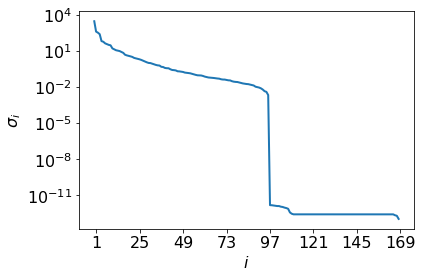

In [ ]:

# plt.plot(S, linewidth=2)
# # plt.plot(S / np.max(S), linewidth=2)


# plt.yscale("log")

# custom_xticks = np.linspace(1, 169, 8)
# plt.xticks(custom_xticks, fontsize=ticks_font)
# plt.yticks(fontsize=ticks_font)


# plt.xlabel(r"$i$", fontsize=label_font)
# plt.ylabel(r"$\sigma_{i}$", fontsize=label_font)

In [11]:
ref_dict = {'mass_ref': mass_ref,
            'momentum_ref':momentum_ref}
np.save(os.path.join(data_path,'K_layer/ref_dict.npy'), ref_dict)